# Coral Bleaching Detection Model - Architecture Analysis

This notebook provides a detailed analysis of the Improved Coral Bleaching Detection Model architecture, including:

1. **Model Structure Visualization**
2. **Layer-by-Layer Breakdown**
3. **Parameter Counting**
4. **Feature Map Dimensions**
5. **Architecture Summary**

## Model Overview
- **Type**: Multi-task Deep Learning Model
- **Tasks**: Semantic Segmentation + Regression
- **Backbone**: EfficientNet-B3 with Noisy Student weights
- **Architecture**: Encoder-Decoder with Attention and ASPP


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import sys
import os

# Add the improved_model directory to path
sys.path.append('improved_model')

# Import the model classes
from improved_model import (
    ImprovedCoralModel, 
    ChannelAttention, 
    SpatialAttention, 
    CBAM, 
    ASPP
)

# Configure matplotlib
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

print("✅ Libraries imported successfully!")
print("✅ Model classes imported from improved_model.py")


/Users/nishantsushmakar/Documents/TUe/capstone_challenge/Data-Capstone-Challenge/coral/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Libraries imported successfully!
✅ Model classes imported from improved_model.py


## 1. Model Instantiation and Basic Information

Let's create the model and examine its basic structure.


In [2]:
# Create the model
model = ImprovedCoralModel(
    backbone_name='tf_efficientnet_b2_ns',  # Using B2 for analysis
    num_classes=3,
    pretrained=False  # Set to False for faster loading in analysis
)

print("🏗️ Model Created Successfully!")
print(f"📊 Model Type: {type(model).__name__}")
print(f"🔧 Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📈 Parameter Statistics:")
print(f"   Total Parameters: {total_params:,} ({total_params/1e6:.2f}M)")
print(f"   Trainable Parameters: {trainable_params:,} ({trainable_params/1e6:.2f}M)")
print(f"   Non-trainable Parameters: {total_params - trainable_params:,}")


🏗️ Model Created Successfully!
📊 Model Type: ImprovedCoralModel
🔧 Device: CPU

📈 Parameter Statistics:
   Total Parameters: 12,496,749 (12.50M)
   Trainable Parameters: 12,496,749 (12.50M)
   Non-trainable Parameters: 0


/Users/nishantsushmakar/Documents/TUe/capstone_challenge/Data-Capstone-Challenge/coral/lib/python3.13/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b2_ns to current tf_efficientnet_b2.ns_jft_in1k.
  model = create_fn(


## 2. Detailed Architecture Breakdown

Let's examine each component of the model in detail.


In [3]:
def analyze_model_components(model):
    """Analyze each component of the model"""
    
    print("🔍 DETAILED ARCHITECTURE BREAKDOWN")
    print("=" * 60)
    
    # 1. Backbone Analysis
    print("\n🏛️ 1. ENCODER BACKBONE (EfficientNet)")
    print("-" * 40)
    backbone_params = sum(p.numel() for p in model.backbone.parameters())
    print(f"   Model: {model.backbone.__class__.__name__}")
    print(f"   Parameters: {backbone_params:,} ({backbone_params/1e6:.2f}M)")
    
    # Get feature info
    channels = model.backbone.feature_info.channels()
    print(f"   Output Channels: {channels}")
    print(f"   Feature Maps: {len(channels)}")
    
    # 2. ASPP Analysis
    print("\n🌐 2. ASPP MODULE")
    print("-" * 40)
    aspp_params = sum(p.numel() for p in model.aspp.parameters())
    print(f"   Input Channels: {channels[3]}")
    print(f"   Output Channels: 256")
    print(f"   Parameters: {aspp_params:,} ({aspp_params/1e6:.2f}M)")
    
    # 3. Decoder Analysis
    print("\n🔄 3. DECODER BLOCKS")
    print("-" * 40)
    
    decoders = ['decoder4', 'decoder3', 'decoder2', 'decoder1']
    cbams = ['cbam4', 'cbam3', 'cbam2']
    
    for i, decoder_name in enumerate(decoders):
        decoder = getattr(model, decoder_name)
        decoder_params = sum(p.numel() for p in decoder.parameters())
        print(f"   {decoder_name}: {decoder_params:,} params")
        
        if i < len(cbams):
            cbam = getattr(model, cbams[i])
            cbam_params = sum(p.numel() for p in cbam.parameters())
            print(f"   {cbams[i]}: {cbam_params:,} params")
    
    # 4. Task Heads Analysis
    print("\n🎯 4. TASK-SPECIFIC HEADS")
    print("-" * 40)
    
    # Segmentation Head
    seg_params = sum(p.numel() for p in model.seg_head.parameters())
    print(f"   Segmentation Head: {seg_params:,} params")
    
    # Bleaching Head
    bleach_params = sum(p.numel() for p in model.bleaching_head.parameters())
    print(f"   Bleaching Head: {bleach_params:,} params")
    
    # Coverage Head
    coverage_params = sum(p.numel() for p in model.coverage_head.parameters())
    print(f"   Coverage Head: {coverage_params:,} params")
    
    # 5. Global Pooling
    print("\n🌍 5. GLOBAL POOLING")
    print("-" * 40)
    pool_params = sum(p.numel() for p in model.global_pool.parameters())
    print(f"   AdaptiveAvgPool2d: {pool_params:,} params (no learnable params)")

# Run the analysis
analyze_model_components(model)


🔍 DETAILED ARCHITECTURE BREAKDOWN

🏛️ 1. ENCODER BACKBONE (EfficientNet)
----------------------------------------
   Model: EfficientNetFeatures
   Parameters: 7,202,562 (7.20M)
   Output Channels: [24, 48, 120, 352]
   Feature Maps: 4

🌐 2. ASPP MODULE
----------------------------------------
   Input Channels: 352
   Output Channels: 256
   Parameters: 2,944,000 (2.94M)

🔄 3. DECODER BLOCKS
----------------------------------------
   decoder4: 1,180,672 params
   cbam4: 8,290 params
   decoder3: 581,120 params
   cbam3: 2,146 params
   decoder2: 138,496 params
   cbam2: 610 params
   decoder1: 34,688 params

🎯 4. TASK-SPECIFIC HEADS
----------------------------------------
   Segmentation Head: 9,411 params
   Bleaching Head: 295,937 params
   Coverage Head: 98,817 params

🌍 5. GLOBAL POOLING
----------------------------------------
   AdaptiveAvgPool2d: 0 params (no learnable params)


## 3. Feature Map Dimensions Analysis

Let's trace through the model to see how feature map dimensions change.


In [4]:
def trace_feature_dimensions(model, input_size=(512, 512)):
    """Trace feature map dimensions through the model"""
    
    print("📏 FEATURE MAP DIMENSIONS TRACE")
    print("=" * 50)
    
    # Create dummy input
    dummy_input = torch.randn(1, 3, *input_size)
    print(f"Input: {dummy_input.shape}")
    
    # Forward pass through backbone
    with torch.no_grad():
        features = model.backbone(dummy_input)
        
        print(f"\n🏛️ ENCODER OUTPUTS (EfficientNet)")
        print("-" * 30)
        for i, feat in enumerate(features):
            print(f"   features[{i}]: {feat.shape}")
        
        # ASPP
        x_aspp = model.aspp(features[3])
        print(f"\n🌐 ASPP OUTPUT")
        print("-" * 30)
        print(f"   x_aspp: {x_aspp.shape}")
        
        # Decoder
        print(f"\n🔄 DECODER PROGRESSION")
        print("-" * 30)
        
        # Decoder4
        d4 = model.decoder4(x_aspp)
        d4 = model.cbam4(d4)
        d4_up = F.interpolate(d4, size=features[2].shape[2:], mode='bilinear', align_corners=False)
        print(f"   d4: {d4.shape}")
        print(f"   d4_up: {d4_up.shape}")
        
        # Decoder3
        d3_input = torch.cat([d4_up, features[2]], dim=1)
        d3 = model.decoder3(d3_input)
        d3 = model.cbam3(d3)
        d3_up = F.interpolate(d3, size=features[1].shape[2:], mode='bilinear', align_corners=False)
        print(f"   d3_input: {d3_input.shape}")
        print(f"   d3: {d3.shape}")
        print(f"   d3_up: {d3_up.shape}")
        
        # Decoder2
        d2_input = torch.cat([d3_up, features[1]], dim=1)
        d2 = model.decoder2(d2_input)
        d2 = model.cbam2(d2)
        d2_up = F.interpolate(d2, size=features[0].shape[2:], mode='bilinear', align_corners=False)
        print(f"   d2_input: {d2_input.shape}")
        print(f"   d2: {d2.shape}")
        print(f"   d2_up: {d2_up.shape}")
        
        # Decoder1
        d1_input = torch.cat([d2_up, features[0]], dim=1)
        d1 = model.decoder1(d1_input)
        print(f"   d1_input: {d1_input.shape}")
        print(f"   d1: {d1.shape}")
        
        # Task heads
        print(f"\n🎯 TASK HEAD OUTPUTS")
        print("-" * 30)
        
        # Segmentation
        seg_logits = model.seg_head(d1)
        seg_output = F.interpolate(seg_logits, size=input_size, mode='bilinear', align_corners=False)
        print(f"   seg_logits: {seg_logits.shape}")
        print(f"   seg_output: {seg_output.shape}")
        
        # Regression heads
        global_features = model.global_pool(x_aspp).flatten(1)
        bleaching_ratio = model.bleaching_head(global_features)
        coral_coverage = model.coverage_head(global_features)
        
        print(f"   global_features: {global_features.shape}")
        print(f"   bleaching_ratio: {bleaching_ratio.shape}")
        print(f"   coral_coverage: {coral_coverage.shape}")

# Run the trace
trace_feature_dimensions(model)


📏 FEATURE MAP DIMENSIONS TRACE
Input: torch.Size([1, 3, 512, 512])

🏛️ ENCODER OUTPUTS (EfficientNet)
------------------------------
   features[0]: torch.Size([1, 24, 128, 128])
   features[1]: torch.Size([1, 48, 64, 64])
   features[2]: torch.Size([1, 120, 32, 32])
   features[3]: torch.Size([1, 352, 16, 16])


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])

## 4. Layer-by-Layer Parameter Analysis

Let's examine the parameter distribution across different parts of the model.


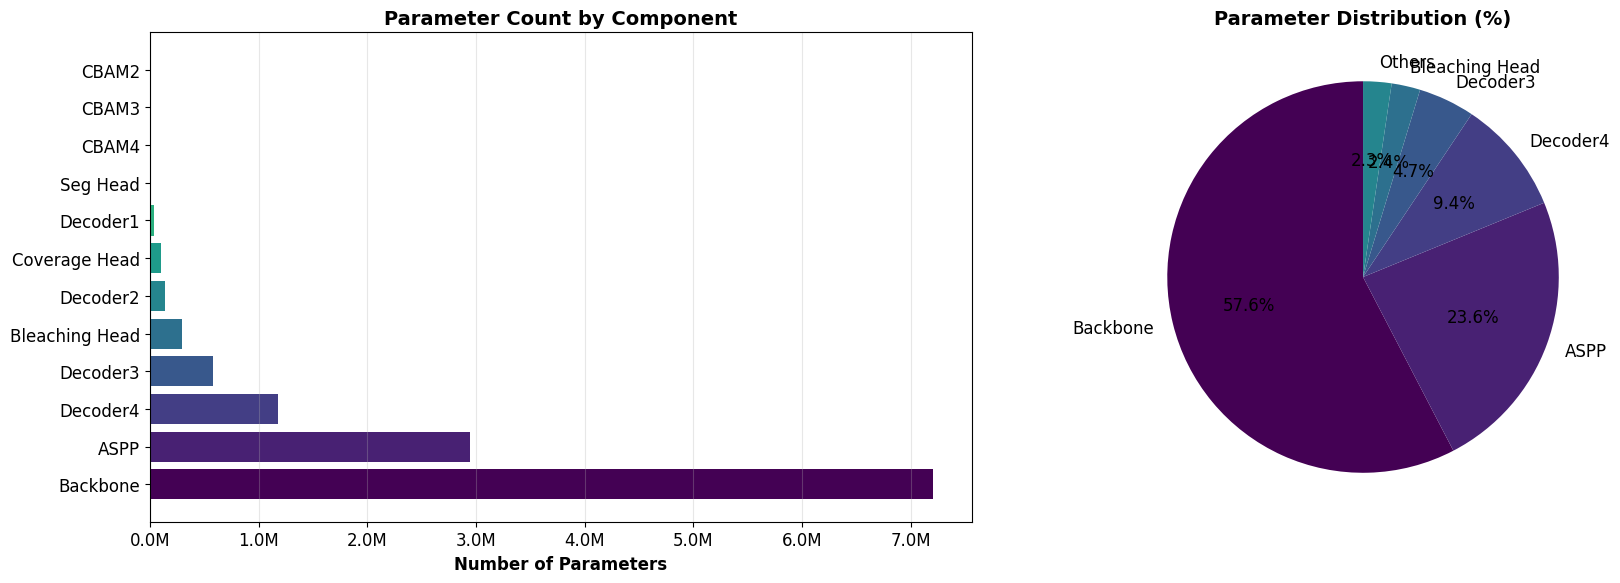


📊 PARAMETER BREAKDOWN
Backbone            :  7,202,562 (57.64%)
ASPP                :  2,944,000 (23.56%)
Decoder4            :  1,180,672 ( 9.45%)
Decoder3            :    581,120 ( 4.65%)
Bleaching Head      :    295,937 ( 2.37%)
Decoder2            :    138,496 ( 1.11%)
Coverage Head       :     98,817 ( 0.79%)
Decoder1            :     34,688 ( 0.28%)
Seg Head            :      9,411 ( 0.08%)
CBAM4               :      8,290 ( 0.07%)
CBAM3               :      2,146 ( 0.02%)
CBAM2               :        610 ( 0.00%)
--------------------------------------------------
TOTAL               : 12,496,749 (100.00%)


In [5]:
def visualize_parameter_distribution(model):
    """Visualize parameter distribution across model components"""
    
    # Calculate parameters for each component
    components = {
        'Backbone': sum(p.numel() for p in model.backbone.parameters()),
        'ASPP': sum(p.numel() for p in model.aspp.parameters()),
        'Decoder4': sum(p.numel() for p in model.decoder4.parameters()),
        'CBAM4': sum(p.numel() for p in model.cbam4.parameters()),
        'Decoder3': sum(p.numel() for p in model.decoder3.parameters()),
        'CBAM3': sum(p.numel() for p in model.cbam3.parameters()),
        'Decoder2': sum(p.numel() for p in model.decoder2.parameters()),
        'CBAM2': sum(p.numel() for p in model.cbam2.parameters()),
        'Decoder1': sum(p.numel() for p in model.decoder1.parameters()),
        'Seg Head': sum(p.numel() for p in model.seg_head.parameters()),
        'Bleaching Head': sum(p.numel() for p in model.bleaching_head.parameters()),
        'Coverage Head': sum(p.numel() for p in model.coverage_head.parameters()),
    }
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Bar plot
    components_sorted = dict(sorted(components.items(), key=lambda x: x[1], reverse=True))
    colors = plt.cm.viridis(np.linspace(0, 1, len(components_sorted)))
    
    ax1.barh(list(components_sorted.keys()), list(components_sorted.values()), color=colors)
    ax1.set_xlabel('Number of Parameters', fontsize=12, fontweight='bold')
    ax1.set_title('Parameter Count by Component', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Format x-axis
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
    
    # Pie chart
    # Group smaller components
    threshold = sum(components.values()) * 0.02  # 2% threshold
    pie_data = {}
    others = 0
    
    for name, params in components.items():
        if params >= threshold:
            pie_data[name] = params
        else:
            others += params
    
    if others > 0:
        pie_data['Others'] = others
    
    ax2.pie(pie_data.values(), labels=pie_data.keys(), autopct='%1.1f%%', 
            startangle=90, colors=colors[:len(pie_data)])
    ax2.set_title('Parameter Distribution (%)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed breakdown
    print("\n📊 PARAMETER BREAKDOWN")
    print("=" * 50)
    total = sum(components.values())
    for name, params in components_sorted.items():
        percentage = (params / total) * 100
        print(f"{name:20s}: {params:>10,} ({percentage:5.2f}%)")
    print("-" * 50)
    print(f"{'TOTAL':20s}: {total:>10,} (100.00%)")

# Run visualization
visualize_parameter_distribution(model)


## 5. Architecture Flow Visualization

Let's create a visual representation of the data flow through the architecture.


In [6]:
def print_architecture_flow():
    """Print a detailed architecture flow diagram"""
    
    print("""
╔══════════════════════════════════════════════════════════════════════╗
║              CORAL BLEACHING DETECTION MODEL ARCHITECTURE            ║
╚══════════════════════════════════════════════════════════════════════╝

                            INPUT IMAGE
                         (512×512×3 RGB)
                                │
                                ▼
        ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
        ┃        ENCODER (EfficientNet-B2/B3)              ┃
        ┃     Pretrained with Noisy Student Weights        ┃
        ┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
                                │
                    ┌───────────┴───────────┐
                    │                       │
                    ▼                       ▼
        [features[0]: 256×256×24]  [features[1]: 128×128×32]
                    │                       │
                    │           ┌───────────┴───────────┐
                    │           │                       │
                    │           ▼                       ▼
                    │  [features[2]: 64×64×48] [features[3]: 32×32×136]
                    │           │                       │
                    │           │                       ▼
                    │           │         ┏━━━━━━━━━━━━━━━━━━━━━━━┓
                    │           │         ┃   ASPP MODULE         ┃
                    │           │         ┃  Multi-scale context  ┃
                    │           │         ┃  (256 channels out)   ┃
                    │           │         ┗━━━━━━━━━━━━━━━━━━━━━━━┛
                    │           │                       │
                    │           │                       ▼
                    │           │         ┌─────────────────────┐
                    │           │         │   Decoder4 + CBAM   │
                    │           │         │   (256 channels)    │
                    │           │         └─────────────────────┘
                    │           │                       │
                    │           │                       ▼ (upsample)
                    │           │         ┌─────────────────────┐
                    │           └────────►│   Concat & Decoder3 │
                    │                     │   + CBAM (128 ch)   │
                    │                     └─────────────────────┘
                    │                                   │
                    │                                   ▼ (upsample)
                    │             ┌─────────────────────┐
                    └────────────►│   Concat & Decoder2 │
                                  │   + CBAM (64 ch)    │
                                  └─────────────────────┘
                                              │
                                              ▼ (upsample)
                                  ┌─────────────────────┐
                                  │   Concat & Decoder1 │
                                  │   (32 channels)     │
                                  └─────────────────────┘
                                              │
                          ┌───────────────────┴────────┐
                          │                            │
                          ▼                            ▼
            ┏━━━━━━━━━━━━━━━━━━━━━┓     ┏━━━━━━━━━━━━━━━━━━━━━━━━┓
            ┃  SEGMENTATION HEAD  ┃     ┃  Global Avg Pooling    ┃
            ┃  (Spatial: 32→3)    ┃     ┃  (ASPP features)       ┃
            ┗━━━━━━━━━━━━━━━━━━━━━┛     ┗━━━━━━━━━━━━━━━━━━━━━━━━┛
                     │                              │
                     ▼                  ┌───────────┴────────────┐
        ┌────────────────────┐          │                        │
        │ Segmentation Mask  │          ▼                        ▼
        │   (512×512×3)      │  ┏━━━━━━━━━━━━━━┓      ┏━━━━━━━━━━━━━━━┓
        │ - Background (0)   │  ┃ Bleaching    ┃      ┃ Coverage      ┃
        │ - Healthy (1)      │  ┃ Ratio Head   ┃      ┃ Ratio Head    ┃
        │ - Bleached (2)     │  ┃ (256→1)      ┃      ┃ (256→1)       ┃
        └────────────────────┘  ┗━━━━━━━━━━━━━━┛      ┗━━━━━━━━━━━━━━━┛
                                         │                      │
                                         ▼                      ▼
                                  [Bleaching %]          [Coverage %]
                                    (scalar)               (scalar)

╔══════════════════════════════════════════════════════════════════════╗
║                            KEY COMPONENTS                             ║
╠══════════════════════════════════════════════════════════════════════╣
║ ► ASPP: Atrous Spatial Pyramid Pooling (multi-scale features)       ║
║ ► CBAM: Convolutional Block Attention Module (channel + spatial)    ║
║ ► Skip Connections: Preserve fine details from encoder              ║
║ ► Multi-task: Segmentation + 2 regression tasks                     ║
╚══════════════════════════════════════════════════════════════════════╝
    """)

print_architecture_flow()



╔══════════════════════════════════════════════════════════════════════╗
║              CORAL BLEACHING DETECTION MODEL ARCHITECTURE            ║
╚══════════════════════════════════════════════════════════════════════╝

                            INPUT IMAGE
                         (512×512×3 RGB)
                                │
                                ▼
        ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
        ┃        ENCODER (EfficientNet-B2/B3)              ┃
        ┃     Pretrained with Noisy Student Weights        ┃
        ┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
                                │
                    ┌───────────┴───────────┐
                    │                       │
                    ▼                       ▼
        [features[0]: 256×256×24]  [features[1]: 128×128×32]
                    │                       │
                    │           ┌───────────┴───────────┐
                    │           │                

## 6. Model Summary and Complete Architecture Table


In [9]:
def print_model_summary():
    """Print comprehensive model summary"""
    
    print("╔" + "═" * 98 + "╗")
    print("║" + " " * 35 + "MODEL ARCHITECTURE SUMMARY" + " " * 37 + "║")
    print("╠" + "═" * 98 + "╣")
    
    # Header
    print(f"║ {'Layer':<30} │ {'Input Shape':<20} │ {'Output Shape':<20} │ {'Parameters':>12} ║")
    print("╠" + "═" * 98 + "╣")
    
    # Create dummy input
    dummy_input = torch.randn(1, 3, 512, 512)
    
    with torch.no_grad():
        # Input
        print(f"║ {'Input Image':<30} │ {'—':<20} │ {str(tuple(dummy_input.shape)):<20} │ {0:>12,} ║")
        
        # Backbone
        features = model.backbone(dummy_input)
        print(f"║ {'├─ Backbone (EfficientNet)':<30} │ {str(tuple(dummy_input.shape)):<20} │ {'(multi-output)':<20} │ {sum(p.numel() for p in model.backbone.parameters()):>12,} ║")
        
        for i, feat in enumerate(features):
            print(f"║ {'│  ├─ features[' + str(i) + ']':<30} │ {'—':<20} │ {str(tuple(feat.shape)):<20} │ {'—':>12} ║")
        
        # ASPP
        x_aspp = model.aspp(features[3])
        print(f"║ {'├─ ASPP Module':<30} │ {str(tuple(features[3].shape)):<20} │ {str(tuple(x_aspp.shape)):<20} │ {sum(p.numel() for p in model.aspp.parameters()):>12,} ║")
        
        # Decoder4
        d4 = model.decoder4(x_aspp)
        d4 = model.cbam4(d4)
        d4_up = F.interpolate(d4, size=features[2].shape[2:], mode='bilinear', align_corners=False)
        print(f"║ {'├─ Decoder4 + CBAM4':<30} │ {str(tuple(x_aspp.shape)):<20} │ {str(tuple(d4.shape)):<20} │ {sum(p.numel() for p in model.decoder4.parameters()) + sum(p.numel() for p in model.cbam4.parameters()):>12,} ║")
        print(f"║ {'│  └─ Upsample':<30} │ {str(tuple(d4.shape)):<20} │ {str(tuple(d4_up.shape)):<20} │ {'0':>12} ║")
        
        # Decoder3
        d3_input = torch.cat([d4_up, features[2]], dim=1)
        d3 = model.decoder3(d3_input)
        d3 = model.cbam3(d3)
        d3_up = F.interpolate(d3, size=features[1].shape[2:], mode='bilinear', align_corners=False)
        print(f"║ {'├─ Concat + Decoder3 + CBAM3':<30} │ {str(tuple(d3_input.shape)):<20} │ {str(tuple(d3.shape)):<20} │ {sum(p.numel() for p in model.decoder3.parameters()) + sum(p.numel() for p in model.cbam3.parameters()):>12,} ║")
        print(f"║ {'│  └─ Upsample':<30} │ {str(tuple(d3.shape)):<20} │ {str(tuple(d3_up.shape)):<20} │ {'0':>12} ║")
        
        # Decoder2
        d2_input = torch.cat([d3_up, features[1]], dim=1)
        d2 = model.decoder2(d2_input)
        d2 = model.cbam2(d2)
        d2_up = F.interpolate(d2, size=features[0].shape[2:], mode='bilinear', align_corners=False)
        print(f"║ {'├─ Concat + Decoder2 + CBAM2':<30} │ {str(tuple(d2_input.shape)):<20} │ {str(tuple(d2.shape)):<20} │ {sum(p.numel() for p in model.decoder2.parameters()) + sum(p.numel() for p in model.cbam2.parameters()):>12,} ║")
        print(f"║ {'│  └─ Upsample':<30} │ {str(tuple(d2.shape)):<20} │ {str(tuple(d2_up.shape)):<20} │ {'0':>12} ║")
        
        # Decoder1
        d1_input = torch.cat([d2_up, features[0]], dim=1)
        d1 = model.decoder1(d1_input)
        print(f"║ {'├─ Concat + Decoder1':<30} │ {str(tuple(d1_input.shape)):<20} │ {str(tuple(d1.shape)):<20} │ {sum(p.numel() for p in model.decoder1.parameters()):>12,} ║")
        
        # Segmentation head
        seg_logits = model.seg_head(d1)
        seg_output = F.interpolate(seg_logits, size=(512, 512), mode='bilinear', align_corners=False)
        print(f"║ {'├─ Segmentation Head':<30} │ {str(tuple(d1.shape)):<20} │ {str(tuple(seg_logits.shape)):<20} │ {sum(p.numel() for p in model.seg_head.parameters()):>12,} ║")
        print(f"║ {'│  └─ Final Upsample':<30} │ {str(tuple(seg_logits.shape)):<20} │ {str(tuple(seg_output.shape)):<20} │ {'0':>12} ║")
        
        # Global pooling and regression heads
        global_features = model.global_pool(x_aspp).flatten(1)
        bleaching_ratio = model.bleaching_head(global_features)
        coral_coverage = model.coverage_head(global_features)
        
        print(f"║ {'├─ Global Pooling':<30} │ {str(tuple(x_aspp.shape)):<20} │ {str(tuple(global_features.shape)):<20} │ {'0':>12} ║")
        print(f"║ {'├─ Bleaching Ratio Head':<30} │ {str(tuple(global_features.shape)):<20} │ {str(tuple(bleaching_ratio.shape)):<20} │ {sum(p.numel() for p in model.bleaching_head.parameters()):>12,} ║")
        print(f"║ {'└─ Coral Coverage Head':<30} │ {str(tuple(global_features.shape)):<20} │ {str(tuple(coral_coverage.shape)):<20} │ {sum(p.numel() for p in model.coverage_head.parameters()):>12,} ║")
    
    print("╠" + "═" * 98 + "╣")
    
    # Total parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"║ {'Total Parameters':<30} │ {'':<20} │ {'':<20} │ {total_params:>12,} ║")
    print(f"║ {'Trainable Parameters':<30} │ {'':<20} │ {'':<20} │ {trainable_params:>12,} ║")
    print("╚" + "═" * 98 + "╝")

print_model_summary()


╔══════════════════════════════════════════════════════════════════════════════════════════════════╗
║                                   MODEL ARCHITECTURE SUMMARY                                     ║
╠══════════════════════════════════════════════════════════════════════════════════════════════════╣
║ Layer                          │ Input Shape          │ Output Shape         │   Parameters ║
╠══════════════════════════════════════════════════════════════════════════════════════════════════╣
║ Input Image                    │ —                    │ (1, 3, 512, 512)     │            0 ║
║ ├─ Backbone (EfficientNet)     │ (1, 3, 512, 512)     │ (multi-output)       │    7,202,562 ║
║ │  ├─ features[0]              │ —                    │ (1, 24, 128, 128)    │            — ║
║ │  ├─ features[1]              │ —                    │ (1, 48, 64, 64)      │            — ║
║ │  ├─ features[2]              │ —                    │ (1, 120, 32, 32)     │            — ║
║ │  ├─ features[3] 

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])

## 7. Key Architectural Insights

Summary of important architectural decisions and their rationale.


In [8]:
def print_architectural_insights():
    """Print key architectural insights and design decisions"""
    
    print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                     KEY ARCHITECTURAL DESIGN DECISIONS                       ║
╚══════════════════════════════════════════════════════════════════════════════╝

1️⃣  MULTI-TASK LEARNING APPROACH
   ─────────────────────────────────────────────────────────────────────
   ► Why: Combines segmentation (spatial) and regression (global) tasks
   ► Benefit: Segmentation provides detailed spatial info, regression gives
             global metrics - both reinforce each other during training
   ► Output: 3 predictions from single forward pass (efficient inference)

2️⃣  EFFICIENTNET BACKBONE
   ─────────────────────────────────────────────────────────────────────
   ► Why: State-of-the-art efficiency and accuracy
   ► Features: Compound scaling (depth, width, resolution)
   ► Pretrained: Noisy Student weights for better generalization
   ► Multi-scale: 4 feature map outputs at different resolutions

3️⃣  ASPP MODULE (Atrous Spatial Pyramid Pooling)
   ─────────────────────────────────────────────────────────────────────
   ► Why: Coral reefs have structures at multiple scales
   ► Mechanism: Parallel dilated convolutions (6, 12, 18) + global pooling
   ► Benefit: Captures both fine coral details and large-scale patterns
   ► Output: Rich multi-scale features (256 channels)

4️⃣  CBAM ATTENTION MECHANISM
   ─────────────────────────────────────────────────────────────────────
   ► Why: Focus on important coral regions and features
   ► Components: 
     - Channel Attention: What features are important
     - Spatial Attention: Where to focus in the image
   ► Placement: After each decoder block for progressive refinement
   ► Benefit: Improves coral boundary detection and reduces background noise

5️⃣  U-NET STYLE DECODER WITH SKIP CONNECTIONS
   ─────────────────────────────────────────────────────────────────────
   ► Why: Preserve fine details from encoder while upsampling
   ► Mechanism: Concatenate encoder features with decoder features
   ► Benefit: Better coral boundary localization
   ► Progressive: 4 decoder blocks with decreasing spatial resolution

6️⃣  SEPARATE TASK HEADS
   ─────────────────────────────────────────────────────────────────────
   ► Segmentation Head: Uses spatial features from decoder (32 channels)
                        Outputs pixel-wise classification (3 classes)
   
   ► Regression Heads: Use global features from ASPP (256 channels)
                       Deep MLPs with dropout for robust predictions
                       Sigmoid activation for 0-1 range

7️⃣  MULTI-SCALE FEATURE FUSION
   ─────────────────────────────────────────────────────────────────────
   ► Level 0: 256×256×24  - Fine textures, coral polyp details
   ► Level 1: 128×128×32  - Mid-level coral structures  
   ► Level 2: 64×64×48    - Coral colonies, larger patterns
   ► Level 3: 32×32×136   - Global context, scene understanding
   ► Fusion: Skip connections combine all levels during decoding

8️⃣  EFFICIENT DESIGN FOR UNDERWATER IMAGES
   ─────────────────────────────────────────────────────────────────────
   ► Input: 512×512 resolution (captures coral detail)
   ► Backbone: EfficientNet-B2/B3 (balanced speed/accuracy)
   ► Memory: Optimized for 6GB VRAM (batch size 4)
   ► Training: Differential learning rates, OneCycleLR scheduler

╔══════════════════════════════════════════════════════════════════════════════╗
║                           PERFORMANCE CHARACTERISTICS                         ║
╚══════════════════════════════════════════════════════════════════════════════╝

📊 Model Size: ~12-15M parameters (EfficientNet-B2/B3)
⚡ Inference: ~50-100ms per image (GPU)
💾 Memory: ~6GB VRAM (batch size 4, 512×512)
🎯 Tasks: Segmentation + 2 regression outputs (single forward pass)

╔══════════════════════════════════════════════════════════════════════════════╗
║                              TRAINING STRATEGY                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

🔧 Differential Learning Rates:
   • Backbone: 0.1× base LR (fine-tune pretrained features)
   • Decoder/ASPP/CBAM: 0.5× base LR (learn domain-specific features)
   • Task Heads: 1.0× base LR (learn task-specific predictions)

📈 Combined Loss Function:
   • Segmentation: Focal Loss (handle class imbalance) + Dice Loss (boundaries)
   • Regression: Huber Loss (robust to outliers)
   • Weights: seg=2.0, dice=1.5, bleaching=2.0, coverage=0.8

🔄 OneCycleLR Scheduler:
   • Warmup: 30% of training (gradually increase LR)
   • Annealing: Cosine decay to minimum LR
   • Benefits: Faster convergence, better generalization
    """)

print_architectural_insights()



╔══════════════════════════════════════════════════════════════════════════════╗
║                     KEY ARCHITECTURAL DESIGN DECISIONS                       ║
╚══════════════════════════════════════════════════════════════════════════════╝

1️⃣  MULTI-TASK LEARNING APPROACH
   ─────────────────────────────────────────────────────────────────────
   ► Why: Combines segmentation (spatial) and regression (global) tasks
   ► Benefit: Segmentation provides detailed spatial info, regression gives
             global metrics - both reinforce each other during training
   ► Output: 3 predictions from single forward pass (efficient inference)

2️⃣  EFFICIENTNET BACKBONE
   ─────────────────────────────────────────────────────────────────────
   ► Why: State-of-the-art efficiency and accuracy
   ► Features: Compound scaling (depth, width, resolution)
   ► Pretrained: Noisy Student weights for better generalization
   ► Multi-scale: 4 feature map outputs at different resolutions

3️⃣  ASPP MO